In [1]:

import pandas as pd
import matplotlib.pyplot as plt

from watertap.core.util.model_diagnostics.infeasible import *
from watertap.core.util.initialization import *

from pyomo.environ import (
    ConcreteModel,
    assert_optimal_termination
)
from pyomo.util.calc_var_value import calculate_variable_from_constraint as cvc

from idaes.core import FlowsheetBlock, UnitModelCostingBlock
from idaes.core.util.model_statistics import *

from watertap.core.solvers import get_solver

from watertap_contrib.reflo.costing import EnergyCosting
from watertap_contrib.reflo.analysis.case_studies.KBHDP.utils import *
from watertap_contrib.reflo.analysis.case_studies.KBHDP.data import *
from watertap_contrib.reflo.solar_models.surrogate.flat_plate.flat_plate_surrogate import (
    FlatPlateSurrogate,
)
from pyomo.environ import (
    value,
)

from idaes.core.util.model_statistics import degrees_of_freedom

from IPython.display import clear_output
from watertap_contrib.reflo.analysis.case_studies.KBHDP import *

plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14

cwd = %pwd

solver = get_solver()

In [2]:
from watertap_contrib.reflo.solar_models.surrogate.pv import PVSurrogate


input_variables = {
    "labels": ["design_size"],
    "bounds": {"design_size": [1000, 10000]},
    "units": {"design_size": "kW"},
}
output_variables = {
    "labels": ["annual_energy", "land_req"],
    "units": {"annual_energy": "kWh", "land_req": "acre"},
}
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.costing = EnergyCosting()
m.fs.pv = PVSurrogate(
    dataset_filename="data/demo_pv.pkl",
    input_variables=input_variables,
    output_variables=output_variables,
    scale_training_data=False,
)
clear_output(wait=False)

In [3]:
rd = build_results_dict(m)

electricity_annual_model = list()
electricity_annual_error = list()
electricity_annual_error_rel = list()

land_req_model = list()
land_req_error = list()
land_req_error_rel = list()

for row in m.fs.pv.data.iterrows():
    m.fs.pv.design_size.fix(row[1].design_size)

    results = solver.solve(m, tee=False)
    assert_optimal_termination(results)
    electricity_annual_model.append(value(m.fs.pv.annual_energy))
    electricity_annual_error.append(value(m.fs.pv.annual_energy) - row[1].annual_energy)
    electricity_annual_error_rel.append(
        100
        * (value(m.fs.pv.annual_energy) - row[1].annual_energy)
        / row[1].annual_energy
    )
    land_req_model.append(value(m.fs.pv.land_req))
    land_req_error.append(value(m.fs.pv.land_req) - row[1].land_req)
    land_req_error_rel.append(
        100 * (value(m.fs.pv.land_req) - row[1].land_req) / row[1].land_req
    )
    rd = results_dict_append(m, rd)

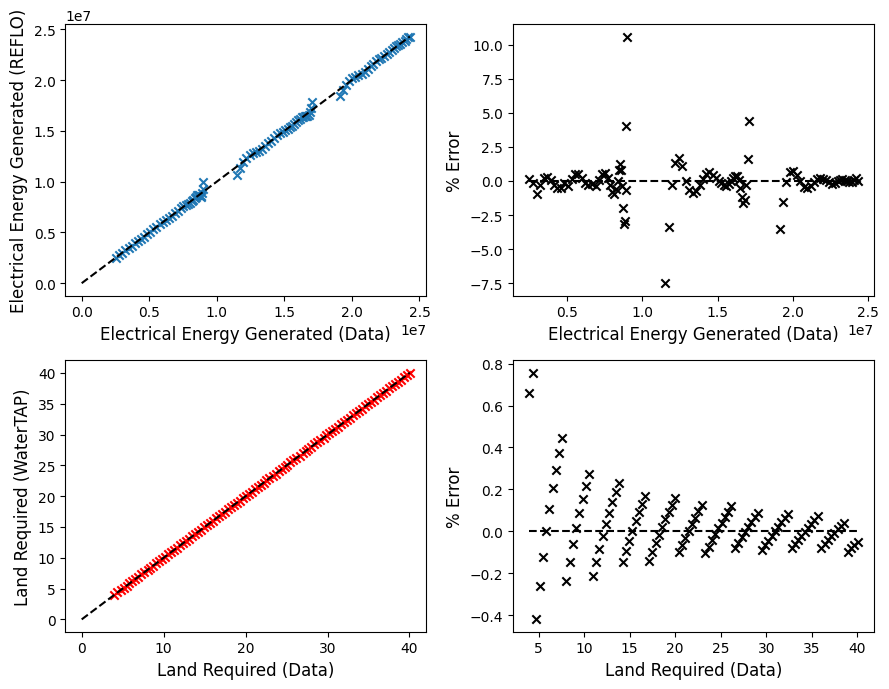

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))
axs[0][0].scatter(
    m.fs.pv.data.annual_energy,
    electricity_annual_model,
    marker="x",
)
axs[0][0].plot(
    [0, max(m.fs.pv.data.annual_energy)],
    [0, max(m.fs.pv.data.annual_energy)],
    color="black",
    linestyle="--",
)
axs[0][0].set(
    xlabel="Electrical Energy Generated (Data)",
    ylabel="Electrical Energy Generated (REFLO)",
)

axs[0][1].scatter(
    m.fs.pv.data.annual_energy, electricity_annual_error_rel, marker="x", color="k"
)
axs[0][1].plot(
    m.fs.pv.data.annual_energy,
    [0 for _ in m.fs.pv.data.annual_energy],
    color="black",
    linestyle="--",
)
axs[0][1].set(xlabel="Electrical Energy Generated (Data)", ylabel="% Error")

axs[1][0].scatter(
    m.fs.pv.data.land_req,
    land_req_model,
    color="red",
    marker="x",
)
axs[1][0].plot(
    [0, max(m.fs.pv.data.land_req)],
    [0, max(m.fs.pv.data.land_req)],
    color="black",
    linestyle="--",
)
axs[1][0].set(xlabel="Land Required (Data)", ylabel="Land Required (WaterTAP)")

axs[1][1].scatter(m.fs.pv.data.land_req, land_req_error_rel, marker="x", color="k")
axs[1][1].plot(
    m.fs.pv.data.land_req,
    [0 for _ in m.fs.pv.data.land_req],
    color="black",
    linestyle="--",
)
axs[1][1].set(xlabel="Land Required (Data)", ylabel="% Error")
fig.tight_layout()

# Create CST Surrogate

In [5]:
from watertap_contrib.reflo.solar_models.surrogate.trough.trough_surrogate import (
    TroughSurrogate,
)

input_bounds = dict(heat_load=[5, 25], hours_storage=[12, 24])
input_units = dict(heat_load="MW", hours_storage="hour")
input_variables = {
    "labels": ["heat_load", "hours_storage"],
    "bounds": input_bounds,
    "units": input_units,
}

output_units = dict(
    heat_annual_scaled="kWh",
    electricity_annual_scaled="kWh",
    total_aperture_area_scaled="m**2",
)
output_variables = {
    "labels": [
        "heat_annual_scaled",
        "electricity_annual_scaled",
        "total_aperture_area_scaled",
    ],
    "units": output_units,
}
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.cst = TroughSurrogate(
    dataset_filename="data/trough_demo_mld.pkl",
    input_variables=input_variables,
    output_variables=output_variables,
    scale_training_data=True,
)

2025-06-26 05:07:58 [INFO] idaes.fs.cst: Training RBF Surrogate with gaussian basis function and algebraic solution method.
2025-06-26 05:07:58 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output heat_annual_scaled trained successfully
2025-06-26 05:07:58 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output electricity_annual_scaled trained successfully


/Users/mhardika/anaconda3/envs/watertap-reflo/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


2025-06-26 05:07:58 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output total_aperture_area_scaled trained successfully
2025-06-26 05:07:58 [INFO] idaes.fs.cst: Training Complete.


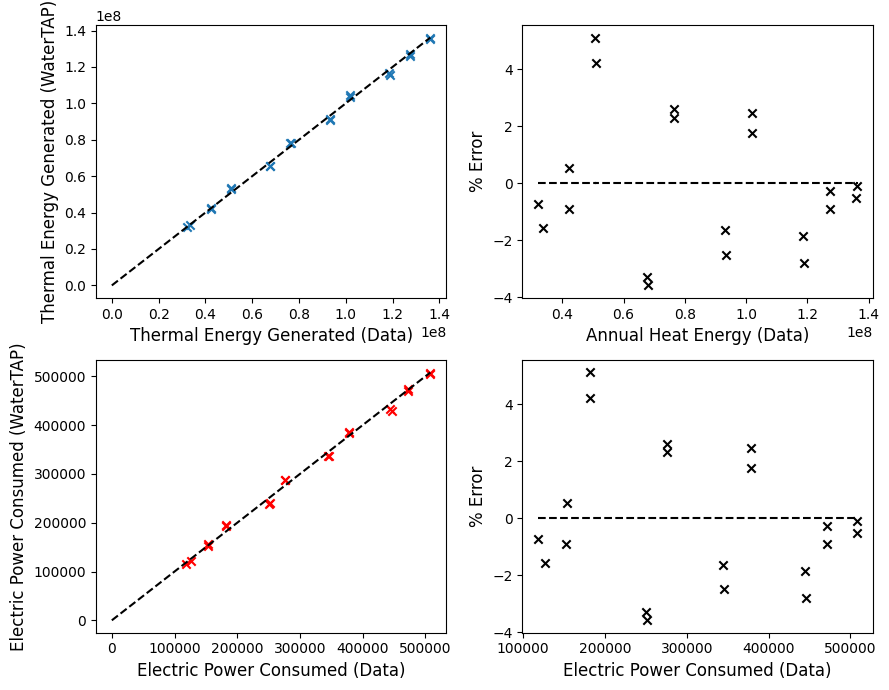

In [6]:
heat_annual_model = list()
heat_annual_error = list()
heat_annual_error_rel = list()

electricity_annual_model = list()
electricity_annual_error = list()
electricity_annual_error_rel = list()

for row in m.fs.cst.data.iterrows():

    m.fs.cst.heat_load.fix(row[1].heat_load)
    m.fs.cst.hours_storage.fix(row[1].hours_storage)
    m.fs.cst.initialize()

    try:
        results = solver.solve(m, tee=False)
    except:
        print_infeasible_constraints(m)
        assert False
    assert_optimal_termination(results)
    heat_annual_model.append(value(m.fs.cst.heat_annual))
    electricity_annual_model.append(value(m.fs.cst.electricity_annual))
    heat_annual_error.append(value(m.fs.cst.heat_annual) - row[1].heat_annual)
    electricity_annual_error.append(
        value(m.fs.cst.electricity_annual) - row[1].electricity_annual
    )
    heat_annual_error_rel.append(
        100 * (value(m.fs.cst.heat_annual) - row[1].heat_annual) / row[1].heat_annual
    )
    electricity_annual_error_rel.append(
        100
        * (value(m.fs.cst.electricity_annual) - row[1].electricity_annual)
        / row[1].electricity_annual
    )
    rd = results_dict_append(m, rd)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))
axs[0][0].scatter(
    m.fs.cst.data.heat_annual,
    heat_annual_model,
    label="Heat Annual Model",
    marker="x",
)
axs[0][0].plot(
    [0, max(m.fs.cst.data.heat_annual)],
    [0, max(m.fs.cst.data.heat_annual)],
    color="black",
    linestyle="--",
)
axs[0][0].set(
    xlabel="Thermal Energy Generated (Data)",
    ylabel="Thermal Energy Generated (WaterTAP)",
)

axs[0][1].scatter(
    m.fs.cst.data.heat_annual, heat_annual_error_rel, marker="x", color="k"
)
axs[0][1].plot(
    m.fs.cst.data.heat_annual,
    [0 for _ in m.fs.cst.data.heat_annual],
    color="black",
    linestyle="--",
)
axs[0][1].set(xlabel="Annual Heat Energy (Data)", ylabel="% Error")
axs[1][0].scatter(
    m.fs.cst.data.electricity_annual,
    electricity_annual_model,
    color="red",
    marker="x",
)
axs[1][0].plot(
    [0, max(m.fs.cst.data.electricity_annual)],
    [0, max(m.fs.cst.data.electricity_annual)],
    color="black",
    linestyle="--",
)
axs[1][0].set(
    xlabel="Electric Power Consumed (Data)", ylabel="Electric Power Consumed (WaterTAP)"
)

axs[1][1].scatter(
    m.fs.cst.data.electricity_annual,
    heat_annual_error_rel,
    label="Electricity Annual Model",
    marker="x",
    color="k",
)
axs[1][1].plot(
    m.fs.cst.data.electricity_annual,
    [0 for _ in m.fs.cst.data.electricity_annual],
    label="Electricity Annual Model",
    color="black",
    linestyle="--",
)
axs[1][1].set(xlabel="Electric Power Consumed (Data)", ylabel="% Error")
fig.tight_layout()

# ONLY STUFF ABOVE HERE!!!

# For creating CST dataset

In [ ]:
# from collections import defaultdict
# cst_param = "/Users/ksitterl/Documents/Python/watertap-reflo/watertap-reflo/src/watertap_contrib/reflo/analysis/case_studies/KBHDP/data/cst/trough_physical_iph-reflo.json"


# t_hots = [80]

# heat_loads = np.linspace(
#     5,
#     25,
#     num=10,
# )
# config_data = read_module_datafile_trough(cst_param)
# tech_model = setup_model_trough(
#     weather_file=weather_file, config_data=config_data
# )
# rd = defaultdict(list)
# for hl in heat_loads:
#     for hs in [12, 24]:
#         tech_model = setup_model_trough(
#     weather_file=weather_file, config_data=config_data
# )
#         result = run_model_trough(
#             tech_model,
#             heat_load=hl,
#             hours_storage=hs,
#             return_tech_model=False,
#         )
#         for k, v in result.items():
#             rd[k].append(v)
#         rd["heat_load"].append(hl)
#         rd["hours_storage"].append(hs)
#         print(f"Heat Load: {hl} MW, Hours Storage: {hs} hr")
#         print(f"Annual Heat: {result['annual_energy']:.2f} kWh")
#         print(f"Annual Electricity: {result['electrical_load']:.2f} kWh")
#         # print(f"LCOH: {result['LCOH']:.4f} $/kWh")
#         clear_output(wait=True)
# df = pd.DataFrame(rd)
# df.to_csv("trough_demo_mld.csv", index=False)
# df.to_pickle("trough_demo_mld.pkl")

# For creating FPC dataset

In [ ]:
# weather_file = "/Users/ksitterl/Documents/Python/watertap-reflo/watertap-reflo/src/watertap_contrib/reflo/analysis/case_studies/KBHDP/data/el_paso_texas-KBHDP-weather.csv"
# param_file = "/Users/ksitterl/Documents/Python/watertap-reflo/watertap-reflo/src/watertap_contrib/reflo/analysis/case_studies/KBHDP/data/fpc/solar_water_heating-kbhdp.json"
# config_data = read_module_datafile_fpc(param_file)
# t_hots = [60, 70, 80, 90]
# t_hots = [80]
# frac_heat_from_solar_min = 0.25
# frac_heat_from_solar_max = 0.9
# thermal_power_min = 0.6  # MW
# thermal_power_max = 12  # MW
# heat_loads = np.linspace(
#     frac_heat_from_solar_min * thermal_power_min,
#     frac_heat_from_solar_max * thermal_power_max,
#     num=10,
# )

# hours_storage = [12, 24]
# data = list()
# for t_hot in t_hots:
#     for hl in heat_loads:
#         for hs in hours_storage:
#             # print(f"Running model with T_hot={t_hot} and MW={hl}")
#             tech_model = setup_model_fpc(
#                 temperatures=dict(T_cold=20, T_hot=t_hot, T_amb=18),
#                 weather_file=weather_file,
#                 config_data=config_data,
#             )
#             result, tech_model = run_model_fpc(
#                 tech_model,
#                 hl,
#                 hours_storage=hs,
#                 temperature_hot=t_hot,
#                 return_tech_model=True,
#             )
#             data.append(
#                 [
#                     hl,
#                     t_hot,
#                     hs,
#                     result["electricity_annual"],
#                     result["heat_annual"],
#                     result["grid_electricity_annual"],
#                     result["scaled_draw"],
#                     result["system_capacity_actual"],
#                     result["temperature_delivered"],
#                 ]
#             )
#             clear_output(wait=True)
# df = pd.DataFrame(
#     data,
#     columns=[
#         "heat_load",
#         "temperature_hot",
#         "hours_storage",
#         "electricity_annual",
#         "heat_annual",
#         "grid_electricity_annual",
#         "scaled_draw",
#         "system_capacity_actual",
#         "temperature_delivered",
#     ],
# )

# df.to_csv("fpc_demo_mld.csv", index=False)
# df.to_pickle("fpc_demo_mld.pkl")
# df = pd.read_pickle("fpc_demo_mld.pkl")

In [ ]:
# df.to_csv("fpc_demo_mld.csv", index=False)
# df.to_pickle("fpc_demo_mld.pkl")
# df = pd.read_pickle("fpc_demo_mld.pkl")

# Create FPC surrogate using new data

In [ ]:
input_bounds = {
    "heat_load": (0.06, 10.8),
    "hours_storage": (12, 24),
    # "temperature_hot": (60, 90),
}
input_units = dict(heat_load="MW", hours_storage="hour", temperature_hot="degK")
input_variables = {
    "labels": ["heat_load", "hours_storage"],
    "bounds": input_bounds,
    "units": input_units,
}

output_units = dict(heat_annual_scaled="kWh", electricity_annual_scaled="kWh")
output_variables = {
    "labels": ["heat_annual_scaled", "electricity_annual_scaled"],
    "units": output_units,
}

m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.costing = EnergyCosting()
m.fs.FPC = FlatPlateSurrogate(
    dataset_filename="fpc_demo_mld.pkl",
    input_variables=input_variables,
    output_variables=output_variables,
    scale_training_data=True,
)
m.fs.FPC.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
m.fs.FPC.heat_load.fix(5)
m.fs.FPC.hours_storage.fix(16)
m.fs.costing.cost_process()
m.fs.costing.add_LCOH()
print(f"degrees of freedom: {degrees_of_freedom(m)}")
m.fs.FPC.initialize()
m.fs.costing.initialize()
results = solver.solve(m, tee=False)
assert_optimal_termination(results)
rd = build_results_dict(m)

In [ ]:
heat_annual_model = list()
electricity_annual_model = list()
heat_annual_error = list()
electricity_annual_error = list()
heat_annual_error_rel = list()
electricity_annual_error_rel = list()

for row in m.fs.FPC.data.iterrows():
    m.fs.FPC.heat_load.fix(row[1].heat_load)
    m.fs.FPC.hours_storage.fix(row[1].hours_storage)
    m.fs.FPC.initialize()
    m.fs.costing.initialize()
    for y, c in m.fs.costing.yearly_heat_production_constraint.items():
        cvc(m.fs.costing.yearly_heat_production[y], c)
    cvc(
        m.fs.costing.lifetime_heat_production,
        m.fs.costing.lifetime_heat_production_constraint,
    )
    try:
        results = solver.solve(m, tee=False)
    except:
        print_infeasible_constraints(m)
        assert False
    assert_optimal_termination(results)
    heat_annual_model.append(value(m.fs.FPC.heat_annual))
    electricity_annual_model.append(value(m.fs.FPC.electricity_annual))
    heat_annual_error.append(value(m.fs.FPC.heat_annual) - row[1].heat_annual)
    electricity_annual_error.append(
        value(m.fs.FPC.electricity_annual) - row[1].electricity_annual
    )
    heat_annual_error_rel.append(
        100 * (value(m.fs.FPC.heat_annual) - row[1].heat_annual) / row[1].heat_annual
    )
    electricity_annual_error_rel.append(
        100
        * (value(m.fs.FPC.electricity_annual) - row[1].electricity_annual)
        / row[1].electricity_annual
    )
    rd = results_dict_append(m, rd)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))
axs[0][0].scatter(
    m.fs.FPC.data.heat_annual,
    heat_annual_model,
    label="Heat Annual Model",
    marker="x",
)
axs[0][0].plot(
    [0, max(m.fs.FPC.data.heat_annual)],
    [0, max(m.fs.FPC.data.heat_annual)],
    color="black",
    linestyle="--",
)
axs[0][0].set(
    xlabel="Thermal Energy Generated (Data)",
    ylabel="Thermal Energy Generated (WaterTAP)",
)

axs[0][1].scatter(
    m.fs.FPC.data.heat_annual, heat_annual_error_rel, marker="x", color="k"
)
axs[0][1].plot(
    m.fs.FPC.data.heat_annual,
    [0 for _ in m.fs.FPC.data.heat_annual],
    color="black",
    linestyle="--",
)
axs[0][1].set(xlabel="Annual Heat Energy (Data)", ylabel="% Error")
axs[1][0].scatter(
    m.fs.FPC.data.electricity_annual,
    electricity_annual_model,
    color="red",
    marker="x",
)
axs[1][0].plot(
    [0, max(m.fs.FPC.data.electricity_annual)],
    [0, max(m.fs.FPC.data.electricity_annual)],
    color="black",
    linestyle="--",
)
axs[1][0].set(
    xlabel="Annual Electric Energy (Data)", ylabel="Annual Electric Energy (WaterTAP)"
)

axs[1][1].scatter(
    m.fs.FPC.data.electricity_annual,
    heat_annual_error_rel,
    label="Electricity Annual Model",
    marker="x",
    color="k",
)
axs[1][1].plot(
    m.fs.FPC.data.electricity_annual,
    [0 for _ in m.fs.FPC.data.electricity_annual],
    label="Electricity Annual Model",
    color="black",
    linestyle="--",
)
axs[1][1].set(xlabel="Annual Electric Energy (Data)", ylabel="% Error")
fig.tight_layout()